# Improving Illumination in Night Time Images

# Part 1: Understanding Codes using Learn OpenCV Tutorial
Program is adapted on these tutorials:
https://learnopencv.com/improving-illumination-in-night-time-images/

By Vardan Agarwal and Lipi Patnaik

# 1. Introduction

Taking good pictures in poor lighting conditions can seem like magic to non-photographers. It takes a combination of skill, experience and the right equipment to accomplish low light photography. Images captured in low light lack color and distinctive edges. They also suffer from poor visibility and unknown depth. These drawbacks make such images inappropriate for personal use or image processing or computer vision tasks. We will learn improving illumination in night time images.

For everyone not blessed with photography skills, we can enhance such images using image processing techniques. A method was presented by Shi et al. for this purpose in their paper, “Nighttime low illumination image enhancement with a single image using bright/dark channel prior.” This paper will act as the base of this post.

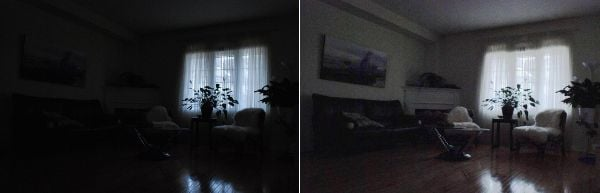

Before and after improving illumination in night time images

For the layman, the solution for low lighting is using flash, but you must have noticed, sometimes flash can result in unwanted effects like red-eye, glare, etc. As a bonus for our dear readers, we will discuss how to rectify pictures with inconvenient lighting and try to solve the limitations faced by this technique.

We will be using this image given below throughout our explanation. The image is taken from the paper cited above.

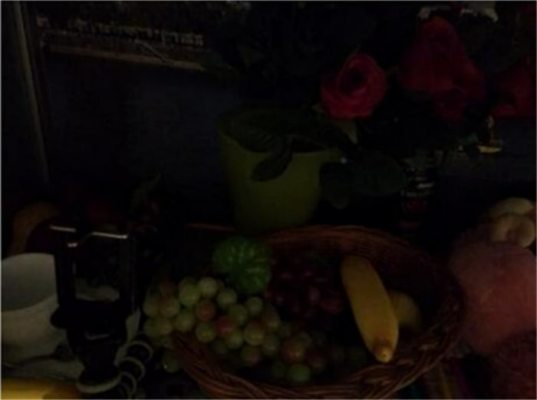

Low-light image

##Table of Content for Part 1
1. Introduction
2. Theory
3. Framework of Improving illumination in night time images
>* Step 1: Obtaining the Bright and Dark Channel Prior
>* Step 2: Computing Global Atmosphere Lighting
>* Step 3: Finding the Initial Transmission Map
>* Step 4: Using Dark Channel to Estimate Corrected Transmission Map
>* Step 5: Smoothing Transmission Map using Guided Filter
>* Step 6: Calculating the Resultant Image
4. Further Improvements
5. Limitations
6. Results
7. Summary

#2. Theory

We aim to utilise a **dual channel prior-based** method for low illumination image enhancement with a **single image**.

Compared to using multiple images, image enhancement with a single image is simpler. Single image enhancement does not need additional assistant images or require exact point-to-point fusion between different images.

Many conventional image processing techniques such as the well-known histogram equalization-based methods, wavelet transform-based method, retinex-based methods can be used to get brighter images. However, they might lead to contrast over-enhancement or noise amplification.

This is where the dual channel prior based solution comes in. An image prior is simply put, “prior information” of an image that you can use in your image processing problem. You would wonder why we use dual channel instead of utilising just the bright channel of a low light image since it would contain the maximum leftout information. Taking the dark channel into consideration removes block effects in some regions and helps see artefacts clearly as illustrated in the image below.

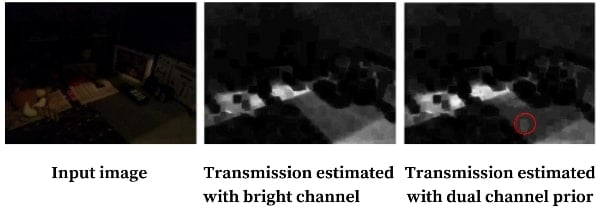

Necessity of dual channel prior


# 3. Framework of Improving Illumination in Night Time Images

Before we dive into enhancing our images let us understand the steps involved. The flowchart below enlists the steps that we will be following in order to obtain an illuminated version of the night-time image.

This is done by first, obtaining the bright and dark channel images. These are just the maximum and minimum pixel values in the local patch of the original image, respectively. Next, we compute the global atmosphere light since that gives us the most information about the relatively brighter parts of the image.

We use the channels and atmospheric light value to obtain the respective transmission maps and take the darkness weights into consideration under special circumstances. We will discuss this in detail Step 4.

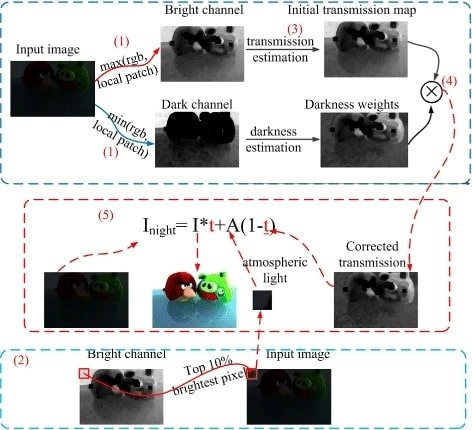

Flowchart to understand the framework of improving illumination in night time images

Now we are all set.

From step 5 in the flow chart, note that the improved illumination image can be found by using the formula:

Equation (1)

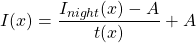

where I(x) is the enhanced image, Inight(x) is the original low-light image, A is the atmospheric light, and t(x) is the corrected transmission map.

## From night_images.py

In [ ]:
import cv2
import numpy as np
import os

Progress Bar

In [ ]:
from tqdm.notebook import tqdm, trange # https://towardsdatascience.com/ever-wanted-progress-bars-in-jupyter-bdb3988d9cfc
                                       # https://towardsdatascience.com/progress-bars-in-python-4b44e8a4c482

##Step 1: Obtaining the Bright and Dark channel Prior
The first step is to estimate the bright and dark channel priors. They represent the maximum and minimum intensity of pixels, respectively, in a local patch. This procedure can be imagined as a sliding convolutional window, helping us find the maximum or minimum value of all channels.

Estimating the dark channel prior

Equation (2)

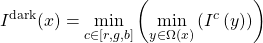

Estimating the bright channel prior

Equation (3)

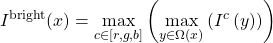

where Ic is a color channel of I and Ω(x) is a local patch centered at x. y is a pixel in the local path Ω(x).

Let us dive into the code now!

In [ ]:
def get_illumination_channel(I, w):
    M, N, _ = I.shape
    padded = np.pad(I, ((int(w/2), int(w/2)), (int(w/2), int(w/2)), (0, 0)), 'edge')
    darkch = np.zeros((M, N))
    brightch = np.zeros((M, N))

    for i, j in np.ndindex(darkch.shape):
        darkch[i, j] = np.min(padded[i:i + w, j:j + w, :])
        brightch[i, j] = np.max(padded[i:i + w, j:j + w, :])

    return darkch, brightch

We first import cv2 and NumPy and write the function to get the illumination channel. The image dimensions are stored in the variables M and N. Padding of half the kernel size is applied to the images to ensure their size remains the same. The dark channel is obtained using np.min to get the lowest pixel value in that block. Similarly, the bright channel is obtained by using np.max to get the highest pixel value in that block. We will need the value of the dark channel and the bright channel for further steps. So we return these values.

The dark and bright channels are obtained by initializing a matrix with zeroes and filling them with values from the image array, where CV_32FC1 defines the depth of each element and the number of channels.

Padding is applied to the images by half the kernel size to ensure their size remains the same. We iterate over the matrix to get the lowest pixel value in that block which is used to set the dark channel pixel value. Obtaining the highest pixel value in that block gives us the bright channel pixel value. cv::minMaxLoc is used to find the global minimum and maximum values in an array.

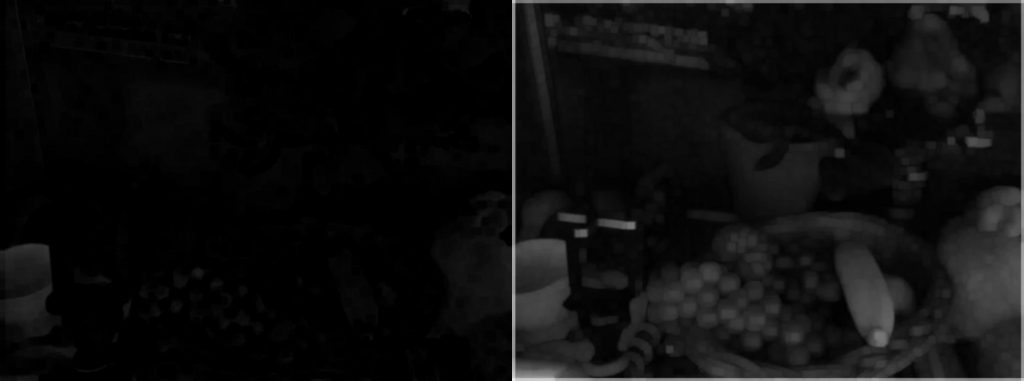

Left – Dark channel prior, Right – Bright channel prior

##Step 2: Computing Global Atmosphere Lighting

The next step is to compute the global atmosphere lighting. It is computed using the bright channel obtained above by taking the mean of the top ten percent intensities. Ten percent of values are taken to ensure that a small anomaly does not affect it highly.

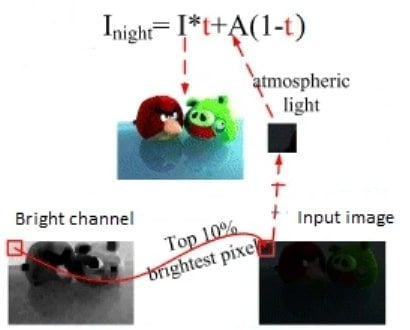

Computation of global atmospheric light and its contribution to improving night time image illumination

In [ ]:
def get_atmosphere(I, brightch, p=0.1):
    M, N = brightch.shape
    flatI = I.reshape(M*N, 3)
    flatbright = brightch.ravel()

    searchidx = (-flatbright).argsort()[:int(M*N*p)]
    A = np.mean(flatI.take(searchidx, axis=0), dtype=np.float64, axis=0)
    return A

To achieve this via code, the image array is reshaped, flattened and sorted according to maximum intensity. The array is sliced to include only the top ten percent of pixels, and then the mean of these is taken.

##Step 3: Finding the Initial Transmission Map

The transmission map describes the portion of the light that is not scattered and reaches the camera. In this algorithm, it will be estimated from the bright channel prior using the following equation:

Equation (4)

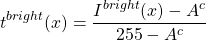

Ac is simply the maximum of a local patch of the atmospheric light.

In [ ]:
def get_initial_transmission(A, brightch):
    A_c = np.max(A)
    init_t = (brightch-A_c)/(1.-A_c)
    return (init_t - np.min(init_t))/(np.max(init_t) - np.min(init_t))

In the code, the initial transmission map is calculated using the formula and then used to calculate the normalized initial transmission map.

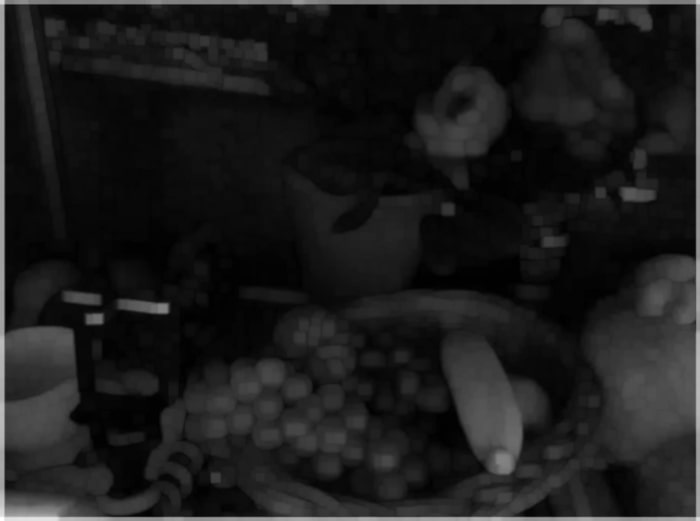

Initial transmission map

##Step 4: Using Dark Channel to Estimate Corrected Transmission Map

A transmission map is also calculated from the dark channel prior, and the difference between the priors is calculated. This calculation is done to correct potentially erroneous transmission estimates attained from the bright channel prior.

Any pixel x with an Idifference channel of less than the set value of alpha (determined by an empirical experiment as 0.4) is in a dark object which makes its depth unreliable. This makes the transmission of pixel x unreliable. Hence the unreliable transmission can be corrected by taking the transmission maps’ product.

In [ ]:
def get_corrected_transmission(I, A, darkch, brightch, init_t, alpha, omega, w):
    im3 = np.empty(I.shape, I.dtype);
    for ind in range(0, 3):
        im3[:, :, ind] = I[:, :, ind] / A[ind]
    dark_c, _ = get_illumination_channel(im3, w)
    dark_t = 1 - omega*dark_c
    corrected_t = init_t
    diffch = brightch - darkch

    for i in range(diffch.shape[0]):
        for j in range(diffch.shape[1]):
            if(diffch[i, j] < alpha):
                corrected_t[i, j] = dark_t[i, j] * init_t[i, j]

    return np.abs(corrected_t)

The above code for Python and below for C++, does precisely this:

We use the get_illumination_channel function we created in the first code snippet to obtain the dark channel transmission map. The parameter omega, usually set to 0.75, is used to correct the initial transmission map. The corrected transmission map is initialized as the initial transmission map. Its value will remain the same as the initial transmission map if the difference between dark and bright channel is more than alpha i.e. 0.4. If the difference at any place is less than alpha, we take the transmission maps’ product as mentioned above.

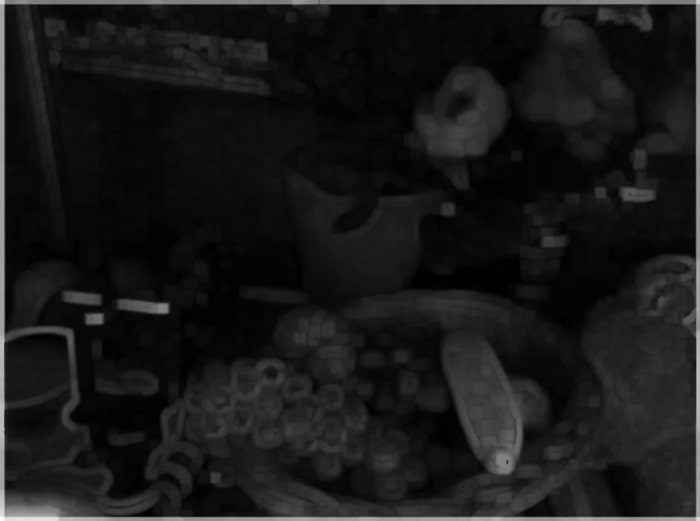

Corrected transmission map

##Step 5: Smoothing Transmission Map using Guided Filter
Let us take a look at the definition of the guided filter.

> Guided image filtering is a neighborhood operation, like other filtering operations, but takes into account the statistics of a region in the corresponding spatial neighborhood in the guidance image when calculating the value of the output pixel.

In essence, it is an edge-preserving smoothing filter. I have used the implementation of this GitHub repository for it. This filter is applied to the corrected transmission map obtained above to get a more refined image.

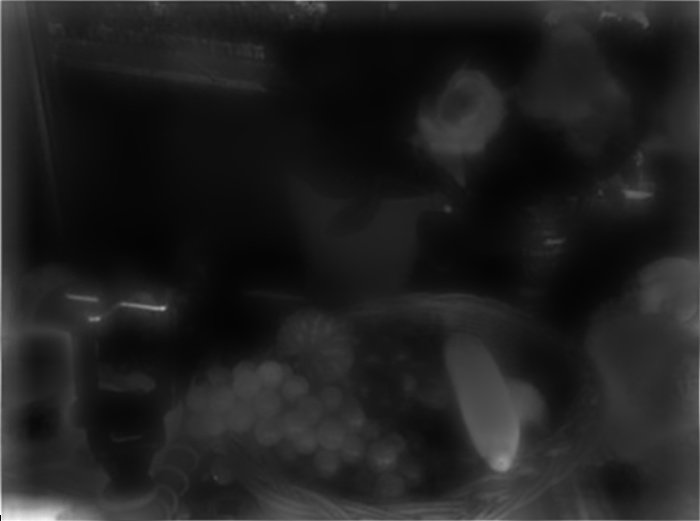

Transmission map obtained after applying guided filter

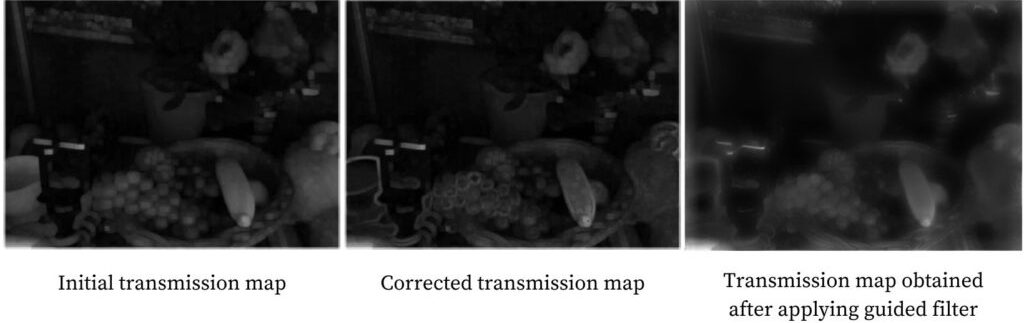

Comparison between transmission maps

## From Guided Filter

Helper functions which will be explained in below sections

In [ ]:
from itertools import combinations_with_replacement
from collections import defaultdict

import numpy as np
from numpy.linalg import inv

B, G, R = 0, 1, 2  # index for convenience

In [ ]:
def boxfilter(I, r):
    """Fast box filter implementation.
    Parameters
    ----------
    I:  a single channel/gray image data normalized to [0.0, 1.0]
    r:  window radius
    Return
    -----------
    The filtered image data.
    """
    M, N = I.shape
    dest = np.zeros((M, N))
    #print(I)

    # cumulative sum over Y axis (tate-houkou no wa)
    sumY = np.cumsum(I, axis=0)
    #print('sumY:{}'.format(sumY))
    # difference over Y axis
    dest[:r + 1] = sumY[r:2*r + 1] # top r+1 lines
    dest[r + 1:M - r] = sumY[2*r + 1:] - sumY[:M - 2*r - 1]
    #print(sumY[2*r + 1:]) # from 2*r+1 to end lines
    #print(sumY[:M - 2*r - 1]) # same lines of above, from start
    #tile replicate sumY[-1] and line them up to match the shape of (r, 1)
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2*r - 1:M - r - 1] # bottom r lines

    # cumulative sum over X axis
    sumX = np.cumsum(dest, axis=1)
    #print('sumX:{}'.format(sumX))
    # difference over X axis
    dest[:, :r + 1] = sumX[:, r:2*r + 1] # left r+1 columns
    dest[:, r + 1:N - r] = sumX[:, 2*r + 1:] - sumX[:, :N - 2*r - 1]
    dest[:, -r:] = np.tile(sumX[:, -1][:, None], (1, r)) - sumX[:, N - 2*r - 1:N - r - 1] # right r columns

    #print(dest)

    return dest

In [ ]:
def guided_filter(I, p, r=15, eps=1e-3):
    """Refine a filter under the guidance of another (RGB) image.
    Parameters
    -----------
    I:   an M * N * 3 RGB image for guidance.
    p:   the M * N filter to be guided. transmission is used for this case.
    r:   the radius of the guidance
    eps: epsilon for the guided filter
    Return
    -----------
    The guided filter.
    """
    M, N = p.shape
    base = boxfilter(np.ones((M, N)), r) # this is needed for regularization

    # each channel of I filtered with the mean filter. this is myu.
    means = [boxfilter(I[:, :, i], r) / base for i in range(3)]

    # p filtered with the mean filter
    mean_p = boxfilter(p, r) / base

    # filter I with p then filter it with the mean filter
    means_IP = [boxfilter(I[:, :, i]*p, r) / base for i in range(3)]

    # covariance of (I, p) in each local patch
    covIP = [means_IP[i] - means[i]*mean_p for i in range(3)]

    # variance of I in each local patch: the matrix Sigma in ECCV10 eq.14
    var = defaultdict(dict)
    for i, j in combinations_with_replacement(range(3), 2):
        var[i][j] = boxfilter(I[:, :, i]*I[:, :, j], r) / base - means[i]*means[j]

    a = np.zeros((M, N, 3))
    for y, x in np.ndindex(M, N):
        #         rr, rg, rb
        # Sigma = rg, gg, gb
        #         rb, gb, bb
        Sigma = np.array([[var[B][B][y, x], var[B][G][y, x], var[B][R][y, x]],
                          [var[B][G][y, x], var[G][G][y, x], var[G][R][y, x]],
                          [var[B][R][y, x], var[G][R][y, x], var[R][R][y, x]]])
        cov = np.array([c[y, x] for c in covIP])
        a[y, x] = np.dot(cov, inv(Sigma + eps*np.eye(3)))  # eq 14

    # ECCV10 eq.15
    b = mean_p - a[:, :, R]*means[R] - a[:, :, G]*means[G] - a[:, :, B]*means[B]

    # ECCV10 eq.16
    q = (boxfilter(a[:, :, R], r)*I[:, :, R] + boxfilter(a[:, :, G], r)*I[:, :, G] + boxfilter(a[:, :, B], r)*I[:, :, B] + boxfilter(b, r)) / base

    return q

##Step 6: Calculating the Resultant Image
A transmission map and the atmospheric light value were required to get the enhanced image. Now that we have the required values, the first equation can be applied to get the result.

In [ ]:
def get_final_image(I, A, refined_t, tmin):
    refined_t_broadcasted = np.broadcast_to(refined_t[:, :, None], (refined_t.shape[0], refined_t.shape[1], 3))
    J = (I-A) / (np.where(refined_t_broadcasted < tmin, tmin, refined_t_broadcasted)) + A

    return (J - np.min(J))/(np.max(J) - np.min(J))

First, the grayscale refined transformation map is converted to a grayscale image to ensure the number of channels in the original image and the transformation map are the same. Next, the output image is calculated using the equation. This image is then max-min normalized and returned from the function.

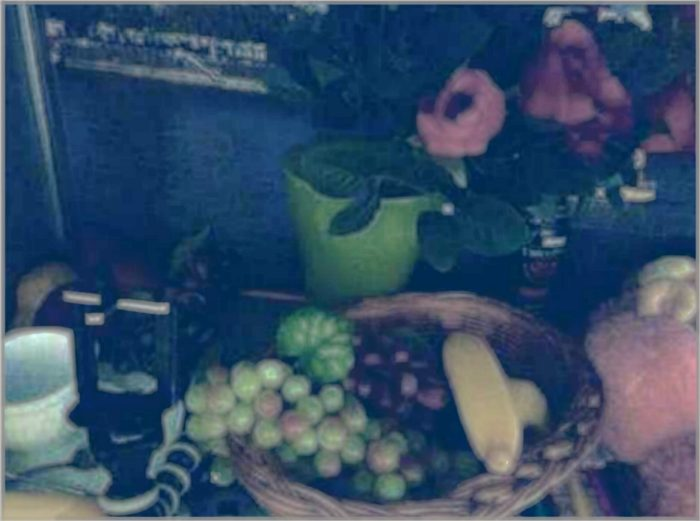

Result obtained

#4. Further Improvements

Although the image is full of color, it looks blurry and sharpening would improve the picture. We can utilize cv2.detailEnhance() for this task but this will increase noise. So we can use  cv2.edgePreservingFilter() to limit it. However, this function will still induce some noise. Hence it is not ideal to do this if the images were noisy from the beginning.

```
img = cv2.detailEnhance(img, sigma_s=10, sigma_r=0.15)
img = cv2.edgePreservingFilter(img, flags=1, sigma_s=64, sigma_r=0.2)
```
For a deeper understanding of these techniques, refer to this [article](https://learnopencv.com/non-photorealistic-rendering-using-opencv-python-c/).

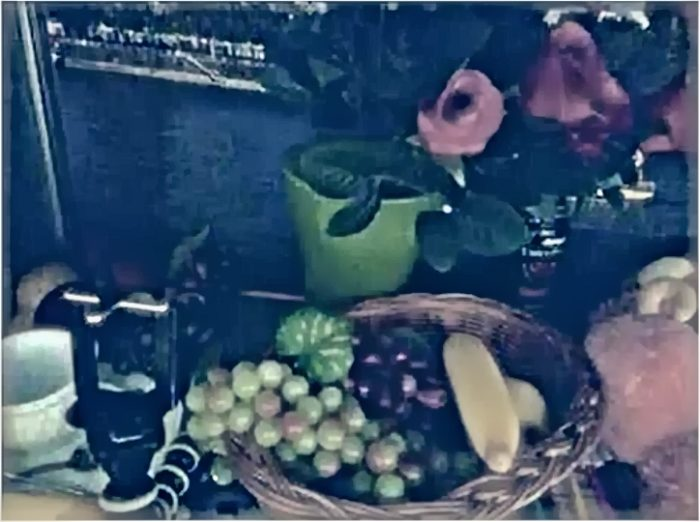

Further enhanced image


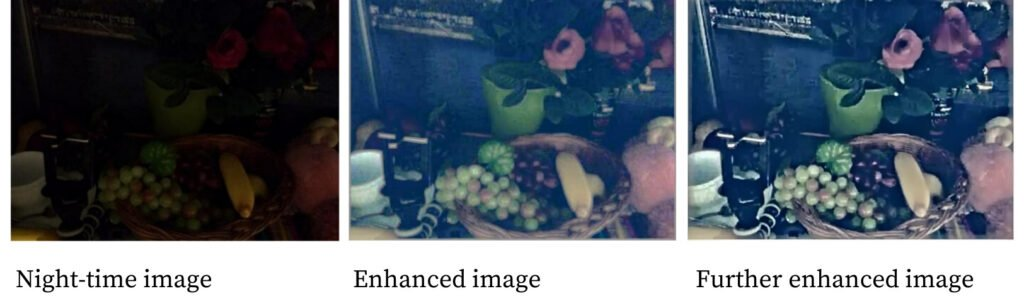

Comparison of original image vs results

#5. Limitations
The method does not perform well if there is any explicit light source in the images such as a lamp or a natural light source like the moon covering a significant portion of the image. Why is this a problem? Because such light sources will push up the value of the atmosphere intensity. As we were looking for the top 10% percent of the brightest pixels, this will cause those areas to overexpose.

This cause and effect is visualized in the image comparison set shown below.

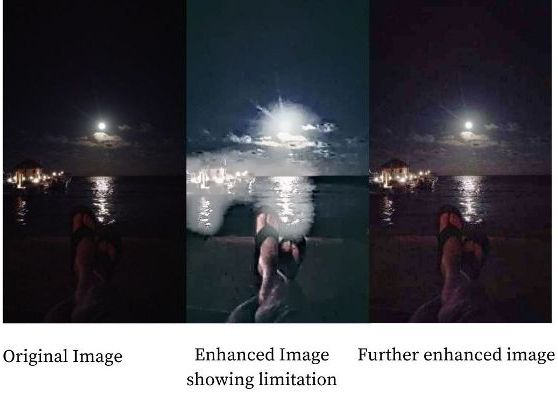

Night-time Image Illumination

To overcome this, let us analyze the initial transmission map made by the bright channel.

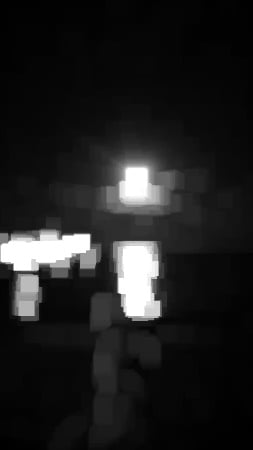

Initial transmission map

The task seems to reduce these intense spots of white, which are causing those areas to over-expose. This can be done by limiting the values from 255 to some minimal value.

In [ ]:
def reduce_init_t(init_t):
    init_t = (init_t*255).astype(np.uint8)
    xp = [0, 32, 255]
    fp = [0, 32, 48]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    init_t = cv2.LUT(init_t, table)
    init_t = init_t.astype(np.float64)/255
    return init_t

To implement this with code, the transmission map is converted to the range of 0-255. A lookup table is then used to interpolate the points from the original values to a new range, which reduces the effect of high exposure.

The graph below is a visual representation of how this tweak in the code would affect the pixels.

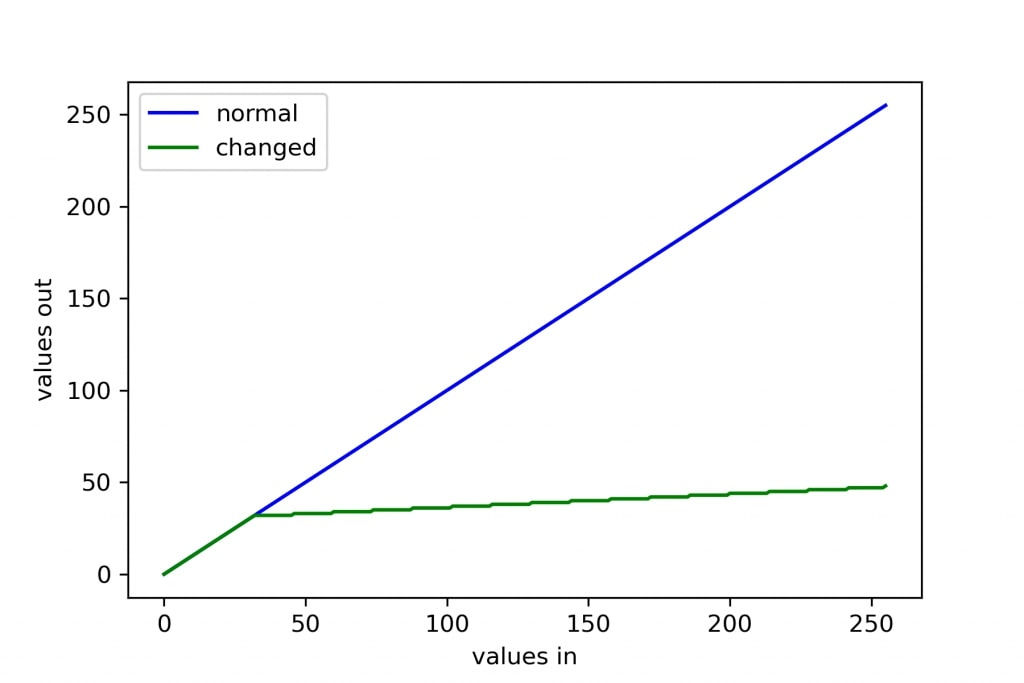

Graphical representation of reducing over exposure

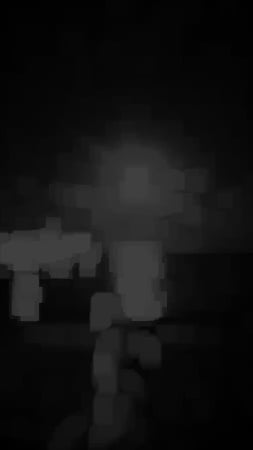

Changed transmission map

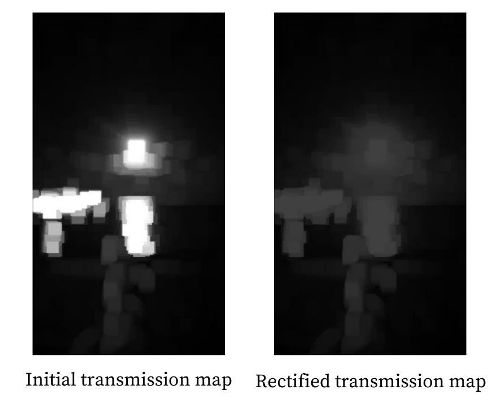

Comparison of transmission maps

We can see the difference between the images obtained by enhancement using the method in the paper and the results obtained following the workaround we have just discussed.

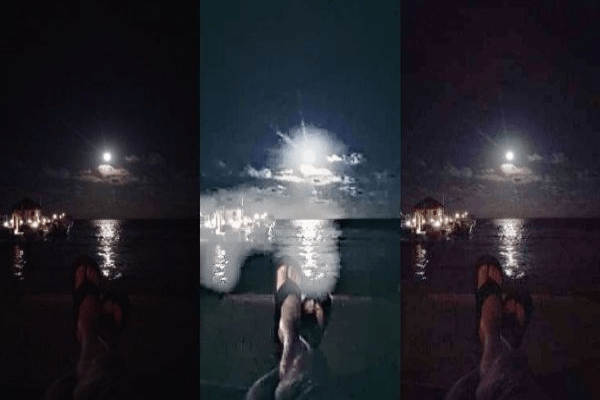

Left – Original image, Center – Enhanced image generated earlier, Right – Further enhanced image. Source of building image. Source of shops image.

#6. Results
The final step is to create a function that combines all the techniques and passes it as an image.

In [ ]:
def dehaze(I, tmin, w, alpha, omega, p, eps, reduce=False):
    m, n, _ = I.shape
    Idark, Ibright = get_illumination_channel(I, w)
    A = get_atmosphere(I, Ibright, p)

    init_t = get_initial_transmission(A, Ibright)
    if reduce:
        init_t = reduce_init_t(init_t)
    corrected_t = get_corrected_transmission(I, A, Idark, Ibright, init_t, alpha, omega, w)

    normI = (I - I.min()) / (I.max() - I.min())
    refined_t = guided_filter(normI, corrected_t, w, eps)
    J_refined = get_final_image(I, A, refined_t, tmin)

    enhanced = (J_refined*255).astype(np.uint8)
    f_enhanced = cv2.detailEnhance(enhanced, sigma_s=10, sigma_r=0.15)
    f_enhanced = cv2.edgePreservingFilter(f_enhanced, flags=1, sigma_s=64, sigma_r=0.2)
    return f_enhanced

Take a look at the gif below showing some other images enhanced with this algorithm.

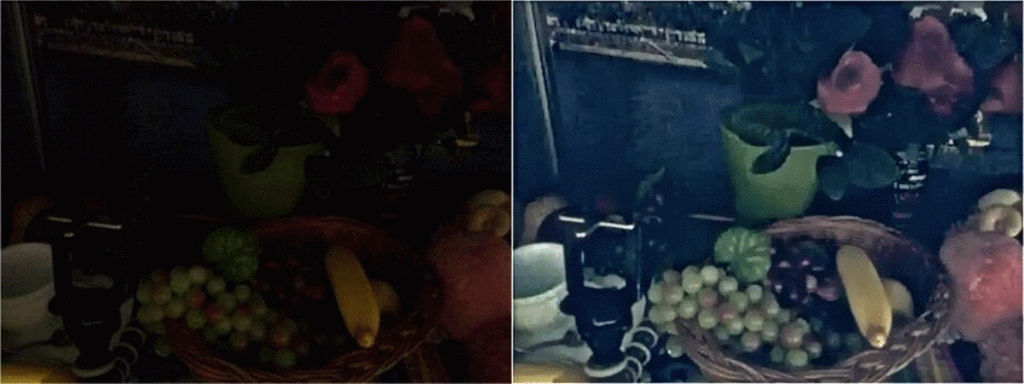

Left: Original Image, Right: Enhanced Image

# 7. Summary
To sum it up, we started with understanding the problems associated with images taken in poor or low lighting conditions. We discussed step by step the method presented by Shi et al. to enhance such images. We also discussed further improvements and limitations of the technique presented in the paper.

The paper presented an excellent technique to increase the illumination of low-light images. However, it works only on those images with constant illumination throughout. As promised, we also explained a workaround to overcome the limitations for images with bright spots, such as a full moon or lamp within the image.

For future development of this method, we can try to control this reduction via a trackbar. The trackbar would help users play around to better understand the appropriate values for enhancement and set the optimum values needed for an individual image.

# Part 2: Batch to Improve Low Lighting Photos

Capturing the Milky Way using mobile phone and using OpenCV to bring out the Milky Way stars is the aspiration of this project.

Steps on mobile phone:
1. Please use App like [Star Walk 2](https://play.google.com/store/apps/details?id=com.vitotechnology.StarWalk2Free&hl=en&gl=US&pli=1) to locate the position of the Milk Way
2. Do have a stable mobile phone tripod as it takes 10 to 15 secs to take one starry sky photo
3. Please use the Pro mode of your mobile phone where you can set the ISO to range of 50-80 and speed to 10 to 15 secs
4. Use voice or Bluetooth clicker activation to trigger camera capture as the mobile need to be very still during the photo capturing

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/Photo')

Mounted at /content/Photo


## Folders info

In your Google Drive, you should create this following folder structure:

My Drive:
* Your photo folder
  * Input
  * Output

'input_path' contains the path where all your low lighting photos.  Example, if your photo folder name is 'Milky_26June2023', the 'input_path' will be as follows:
```
input_path = '/content/Photo/My Drive/Milky_26June2023/Input'
```

'output_path' contains the path where all your processed low lighting photos.  Example, if your photo folder name is 'Milky_26June2023', the 'output_path' will be as follows:
```
output_path = '/content/Photo/My Drive/Milky_26June2023/Output'
```
All processed photos will havesame file name as the original with a postfix of '_a_n' where 'n' is the no. of photos processed.




In [ ]:
# User's Gooogle Drive:
input_path = '/content/Photo/My Drive/Milky_26June2023/Input'    # Where the photos are stored to be processed
output_path = '/content/Photo/My Drive/Milky_26June2023/Output'  # Where the processed photos to be stored

# find all files paths from the folder
images = [os.path.join(input_path, f) for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]

no_of_images = len(images)
print("No. of images: ", no_of_images)

No. of images:  6


# Program Main Loop

Here is where each photo will be batch processed.

In [ ]:
i = 0
p_bar = tqdm(range(100)) # progress bar init

# Parameters
tmin = 0.1   # minimum value for t to make J image
w = 15       # window size, which determine the corseness of prior images
alpha = 0.4  # threshold for transmission correction
omega = 0.75 # this is for dark channel prior
p = 0.1      # percentage to consider for atmosphere
eps = 1e-3   # for J image

update_value = (1/no_of_images)*100 # For Progress bar

for img in images:

    im = cv2.imread(img)

    file_str1 = img.split('.')
    file_str2 = file_str1[0].split('/')
    file_name = file_str2[-1]

    I = np.asarray(im, dtype=np.float64) # Convert the input to an array.
    I = I[:, :, :3] / 255

    f_enhanced2 = dehaze(I, tmin, w, alpha, omega, p, eps, True)

    # write image to the disk
    new_file_path = '%s/%s_a_%s.png' % (output_path, file_name, i)
    print(new_file_path)
    cv2.imwrite(new_file_path, f_enhanced2)
    i = i + 1 # Update count => which the output file name

    # Update progress Bar
    p_bar.update(update_value)

cv2.destroyAllWindows()

  0%|          | 0/100 [00:00<?, ?it/s]

/content/Photo/My Drive/Milky_26June2023/Output/20230626_202223_a_0.png
/content/Photo/My Drive/Milky_26June2023/Output/20230626_202300_a_1.png
/content/Photo/My Drive/Milky_26June2023/Output/20230626_202555_a_2.png
/content/Photo/My Drive/Milky_26June2023/Output/20230626_202748_a_3.png
/content/Photo/My Drive/Milky_26June2023/Output/20230626_203417_a_4.png
/content/Photo/My Drive/Milky_26June2023/Output/20230626_204728_a_5.png
